# Arabic Books Classification

After Scrapping our data, we will preprocess it (Clean, Normalize and Enrich) in order to apply Classification Algorithms (Logistic Regression, Naive Bayes, K-nearest neighbour) to Classify our books into different categories.

## 1) Preprocessing

First, Let's import all the needed modules and load the data.

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.charsets import AR_LETTERS_CHARSET
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline
mle_pretrained = MLEDisambiguator.pretrained()

In [2]:
#initializing stop words array
stopwords = []
with open('C:/Users/Dalia/Downloads/Graduation Project/Data/arabic-stop-words-master/list.txt', encoding='utf8') as file:
    for line in file:
        stopwords.append(line.strip())


In [3]:
#load_the_data
data = pd.read_csv("Books1.csv")
data.head(10)

,الكتب,الكاتب,سنة النشر,دار النشر,قسم الكتاب,تلخيص الكتاب,عدد الصفحات
0,الجمعية السرية للمواطن..,أشرف العشماوي,2021,المصرية اللبنانية للنشر والتوزيع,روايات,أبطال هذه الرواية شخصيات غير تقليدية لكننا نصا...,200
1,مصور الاطفال - الثياب,إميلي بومون وَ ناتالي بيلينو,2021,المجاني للنشر والتوزيع,قصص الأطفال,"مصور الأطفال, كتاب جميل, مصنوع من الورق المقوى...",177
2,انظر داخل - المزرعة,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,كتب وموسوعات للأطفال,ارفع الطيات لاستكشاف أنواع مختلفة من الأليات ا...,253
3,انظر داخل - الفضاء,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,كتب وموسوعات للأطفال,سلسلة كتب يتطرق كل منها الى موضوع معين، وتتميز...,231
4,اكتشف داخل - حديقة الح..,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,قصص الأطفال,إسترق النظر تحت أوراق الشجر وخلف الأبواب لتجد ...,391
5,My Little Darling - Ra..,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,قصص الأطفال,"A book full of tenderness, showing the mother’...",183
6,My Little Darling - Po..,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,قصص الأطفال,"A book full of tenderness, showing the mother’...",261
7,My Little Darling - Do..,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,قصص الأطفال,"A book full of tenderness, showing the mother’...",415
8,My Little Darling - Co..,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,قصص الأطفال,"A book full of tenderness, showing the mother’...",391
9,My Little Darling - Be..,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,قصص الأطفال,"A book full of tenderness, showing the mother’...",448


In [4]:
# remove our outliers based on the no. of pages
data = data[data['عدد الصفحات']< 500] 
data['عدد الصفحات'].value_counts()

16     49
24     47
32     44
160    29
64     26
       ..
211     1
165     1
454     1
451     1
63      1
Name: عدد الصفحات, Length: 376, dtype: int64

In [5]:
#remove any row that contain non-arabic books
for i in data.index:
    text = data.at[i, "الكتب"][0]
    #print(text)
    if text.encode().isalpha():
        data.drop(i, inplace=True)
data.head(10)

,الكتب,الكاتب,سنة النشر,دار النشر,قسم الكتاب,تلخيص الكتاب,عدد الصفحات
0,الجمعية السرية للمواطن..,أشرف العشماوي,2021,المصرية اللبنانية للنشر والتوزيع,روايات,أبطال هذه الرواية شخصيات غير تقليدية لكننا نصا...,200
1,مصور الاطفال - الثياب,إميلي بومون وَ ناتالي بيلينو,2021,المجاني للنشر والتوزيع,قصص الأطفال,"مصور الأطفال, كتاب جميل, مصنوع من الورق المقوى...",177
2,انظر داخل - المزرعة,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,كتب وموسوعات للأطفال,ارفع الطيات لاستكشاف أنواع مختلفة من الأليات ا...,253
3,انظر داخل - الفضاء,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,كتب وموسوعات للأطفال,سلسلة كتب يتطرق كل منها الى موضوع معين، وتتميز...,231
4,اكتشف داخل - حديقة الح..,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,قصص الأطفال,إسترق النظر تحت أوراق الشجر وخلف الأبواب لتجد ...,391
12,100000 لماذا - الأرض,مجموعة مؤلفين,2020,الدار العربية للعلوم ناشرون,كتب وموسوعات للأطفال,مئة ألف لماذا هي مجموعة من الكتب العلمية التي ...,415
13,أزمة المناخ,نعوم جومسكي,2021,الدار العربية للعلوم ناشرون,علوم البيئة,"في مؤلفهما المشترك المعنون ""أزمة المناخ"" يناقش...",48
14,تفاح أمريكاني,أحمد أبو الفتوح,2021,الدار العربية للعلوم ناشرون,قصص قصيرة,ستحضر الكاتب حيًا شعبيًا يعيش داخله أُناسه الأ...,294
15,العودة,نيكولاس سباركس,2021,الدار العربية للعلوم ناشرون,روايات,"بأسلوبه الروائي الرومانسي في رواية ""عزيزي جون""...",286
16,مساعدة الأطفال والمراه..,جوان ستير,2021,الدار العربية للعلوم ناشرون,تربية,يستهدف الكتاب الأطفال والشباب الذين تتراوح أعم...,65


In [6]:
#investigate the column that we will classify books based on it
categories = data['قسم الكتاب'].value_counts() # it contains 54 different category
print(type(categories))
print(categories.count())
categories

<class 'pandas.core.series.Series'>
54


روايات                   424
قصص الأطفال              297
كتب وموسوعات للأطفال      78
أدب                       76
أنشطة ومهارات للأطفال     51
قصص قصيرة                 45
فلسفة                     33
تاريخ                     30
علوم                      29
تنمية ذاتية               28
مقالات                    27
كوميكس                    21
فكر                       21
تراجم وسير                20
قصص                       19
علم نفس                   17
تربية                     17
كتب متنوعة                13
سيرة ذاتية                11
صحة نفسية                 10
نصوص                      10
إدارة أعمال               10
دراسات                     9
شعر                        7
علوم طبيعية                7
سياسة                      7
مذكرات                     6
قصص وروايات                5
ديوان شعرى                 4
تربية الأطفال              4
خيال علمى                  4
تطوير الذات والعلاقات      4
علاقات اجتماعية            4
اقتصاد                     3
صحة           

Our data will be classified based on the category of the book, we have about 55 categories, most of them are either repeated or have not enough books (about 1 or 2 books) categorized as these types.<br>
So, we will reduce our categories to 12 categories containing the most populer categories and the category "متنوع".

In [7]:
#let's create a dictionary to compare our types to
Label_names = {}
m = 0
for i in list(categories.index[:11]):
    Label_names[i] = m
    m += 1
Label_names

{'روايات': 0,
 'قصص الأطفال': 1,
 'كتب وموسوعات للأطفال': 2,
 'أدب': 3,
 'أنشطة ومهارات للأطفال': 4,
 'قصص قصيرة': 5,
 'فلسفة': 6,
 'تاريخ': 7,
 'علوم': 8,
 'تنمية ذاتية': 9,
 'مقالات': 10}

In [8]:
for ind in data.index:
    data.at[ind, "نوع"] = Label_names.get(data.at[ind, 'قسم الكتاب'],11)
data.head()

,الكتب,الكاتب,سنة النشر,دار النشر,قسم الكتاب,تلخيص الكتاب,عدد الصفحات,نوع
0,الجمعية السرية للمواطن..,أشرف العشماوي,2021,المصرية اللبنانية للنشر والتوزيع,روايات,أبطال هذه الرواية شخصيات غير تقليدية لكننا نصا...,200,0.0
1,مصور الاطفال - الثياب,إميلي بومون وَ ناتالي بيلينو,2021,المجاني للنشر والتوزيع,قصص الأطفال,"مصور الأطفال, كتاب جميل, مصنوع من الورق المقوى...",177,1.0
2,انظر داخل - المزرعة,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,كتب وموسوعات للأطفال,ارفع الطيات لاستكشاف أنواع مختلفة من الأليات ا...,253,2.0
3,انظر داخل - الفضاء,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,كتب وموسوعات للأطفال,سلسلة كتب يتطرق كل منها الى موضوع معين، وتتميز...,231,2.0
4,اكتشف داخل - حديقة الح..,مجموعة مؤلفين,2021,المجاني للنشر والتوزيع,قصص الأطفال,إسترق النظر تحت أوراق الشجر وخلف الأبواب لتجد ...,391,1.0


Our column "نوع" will be the label column we will categorize on, it contains our 12 categories with labels from 0 - 11.

In [9]:
data["نوع"].value_counts() # now we have 12 categories

0.0     424
1.0     297
11.0    268
2.0      78
3.0      76
4.0      51
5.0      45
6.0      33
7.0      30
8.0      29
9.0      28
10.0     27
Name: نوع, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1386 entries, 0 to 1520
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   الكتب         1386 non-null   object 
 1   الكاتب        1386 non-null   object 
 2   سنة النشر     1386 non-null   int64  
 3   دار النشر     1386 non-null   object 
 4   قسم الكتاب    1386 non-null   object 
 5   تلخيص الكتاب  1386 non-null   object 
 6   عدد الصفحات   1386 non-null   int64  
 7   نوع           1386 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 129.7+ KB


we preprocess our data using 3 steps: 

### 1) Cleaning our data:

    remove urls
    Mentions
    Emotions
    Symbols
    Diacritical marks
    Shapes
    Unwanted Punctuation (basicly anything that is not an arabic word or a number).

In [11]:
def clean_text(text):
    sentence_ar_dediac = dediac_ar(text) #dediacritization using camel tools
    sentence_ar_dediac = re.sub(r"\S*https?:\S*|@\S+", "", sentence_ar_dediac) #remove URLs and mentions even if they are in paranthesis or brackets
    no_punc = ""
    for char in sentence_ar_dediac:
        if char in (list(AR_LETTERS_CHARSET)+[" "]): #removing any thing that is not an arabic letter
            no_punc = no_punc + char
    return no_punc

### 2) Normalizing our data
    Orthographic Normalization
    Unicode Normalization

In [12]:
def normalize_text(text):
    cleaned_text = normalize_alef_maksura_ar(text)
    cleaned_text = normalize_alef_ar(cleaned_text)
    cleaned_text = normalize_teh_marbuta_ar(cleaned_text)
    cleaned_text = normalize_unicode(cleaned_text)
    
    return cleaned_text

### 3) Stopwords and tokenization

In [13]:
def enrichement(text, stopwords=stopwords):
    tokens = simple_word_tokenize(text)
    tokenized = []
    for token in tokens:
        if token not in stopwords:
            tokenized.append(token)
         
    disambig = mle_pretrained.disambiguate(tokenized)
    lemmas = [d.analyses[0].analysis['lex'] for d in disambig]
    return lemmas

In [14]:
def preprocess_text(text, clean_text=clean_text, normalize_text=normalize_text, enrichement=enrichement):
    '''
    Inputs:
    text: string in which it will preprocess.
    
    Outputs:
    cleaned_text: the string after it was processed.
    '''
    
    #let's first start with cleaning 
    cleaned = clean_text(text)
                
    # now, for the normalization part
    normalized = normalize_text(cleaned)
    
    #enrichement
    enriched = enrichement(normalized)
    #return normalized
    return enriched

In [15]:
def preprocess_data(data, preprocess_text=preprocess_text):
    '''
    Inputs:
    data: is the dataframe we want to apply our function on
    
    Outputs:
    data: the dataframe after applying the cleaning and normalization on each cell.
    
    '''
    for row in range(data.shape[0]):
        for column in range(data.shape[1]):
            for_cleaning = str(data.iloc[row][column])
            data.iloc[row][column] = preprocess_text(for_cleaning)
    return data


In [16]:
data_original = data.copy()
data = data[['الكتب', 'الكاتب', 'دار النشر', 'قسم الكتاب', 'تلخيص الكتاب']]
data = preprocess_data(data)
data.shape

(1386, 5)

In [17]:
data.head(30)

,الكتب,الكاتب,دار النشر,قسم الكتاب,تلخيص الكتاب
0,"[جَمْعِيَّة, سِرِّيّ, مُواطِن]","[أَشْرَف, العشماوي]","[مِصْرِيّ, لُبْنانِيّ, نَشْر, تَوْزِيع]",[رِوايَة],"[بَطَل, رِوايَة, شَخْصِيَّة, تَقْلِيدِيّ, لٰكِ..."
1,"[مُصَوِّر, طِفْل, ثَوْب]","[أَمْيَل, بومون, ناتالِي, بيلينو]","[مَجّانِيّ, نَشْر, تَوْزِيع]","[قِصَّة, طِفْل]","[مُصَوِّر, طِفْل, كِتاب, جَمِيل, مَصْنُوع, وَر..."
2,"[نَظَر, داخِل, مَزْرَع]","[مَجْمُوع, مُؤَلِّف]","[مَجّانِيّ, نَشْر, تَوْزِيع]","[كَتَب, مَوْسُوعَة, طِفْل]","[رَفَع, طَيَّة, ٱِسْتِكْشاف, نَوْع, مُخْتَلِف,..."
3,"[نَظَر, داخِل, فَضاء]","[مَجْمُوع, مُؤَلِّف]","[مَجّانِيّ, نَشْر, تَوْزِيع]","[كَتَب, مَوْسُوعَة, طِفْل]","[سِلْسِلَة, كَتَب, تَطَرَّق, مَوْضُوع, مُعَيَّ..."
4,"[ٱِكْتَشَف, داخِل, حَدِيقَة, أَلَحّ]","[مَجْمُوع, مُؤَلِّف]","[مَجّانِيّ, نَشْر, تَوْزِيع]","[قِصَّة, طِفْل]","[ٱِسْتَرَق, نَظَر, وَرَق, شَجَرَة, خَلَّف, باب..."
12,"[لِماذا, أَرْض]","[مَجْمُوع, مُؤَلِّف]","[دار, عَرَبِيّ, عِلْم, ناشِر]","[كَتَب, مَوْسُوعَة, طِفْل]","[مِئَة, لِماذا, مَجْمُوع, كِتاب, عِلْمِيّ, تَق..."
13,"[أَزْمَة, مُناخ]","[عام, جومسكي]","[دار, عَرَبِيّ, عِلْم, ناشِر]","[عِلْم, بِيئَة]","[مُؤَلِّف, مُشْتَرَك, مُعَنْوَن, أَزْمَة, مُنا..."
14,"[تُفّاح, أَمْرِيكِيّ]","[أَحْمَد, أَبُو, فَتْح]","[دار, عَرَبِيّ, عِلْم, ناشِر]","[قِصَّة, قَصِير]","[حَضَر, كاتِب, حَيّ, شَعْبِيّ, عاش, داخِل, إِن..."
15,[عَوْدَة],"[نِيكُولاس, سباركس]","[دار, عَرَبِيّ, عِلْم, ناشِر]",[رِوايَة],"[أُسْلُوب, رِوائِيّ, رُومانْسِيّ, رِوايَة, عَز..."
16,"[مُساعِد, طِفْل, مَرْأَة]",[ستير],"[دار, عَرَبِيّ, عِلْم, ناشِر]",[تَرْبِيَة],"[ٱِسْتَهْدَف, كِتاب, طِفْل, شَبّ, تَراوَح, عُم..."


In [18]:
data.tail(30)

,الكتب,الكاتب,دار النشر,قسم الكتاب,تلخيص الكتاب
1487,"[لَوْن, رِئاسَة]","[دار, بُسْتانِيّ, نَشْر, تَوْزِيع]","[دار, بُسْتانِيّ, نَشْر, تَوْزِيع]","[نَشاط, مَهارَة, طِفْل]","[كُرّاس, تَلْوِين, كَبِير, طِفْل]"
1489,"[كَتَب, لَوْن, مَعْي, حَرْف, ال]","[دار, بُسْتانِيّ, نَشْر, تَوْزِيع]","[دار, بُسْتانِيّ, نَشْر, تَوْزِيع]","[نَشاط, مَهارَة, طِفْل]","[تَعْلِيم, كِتاب, قِراءَة, حَرْف, عَرَبِيّ, تَ..."
1490,"[أَعْظَم, آب, وُجُود]","[دَوِيّ, بُسْتانِيّ]","[دار, بُسْتانِيّ, نَشْر, تَوْزِيع]",[قِصَّة],"[بابا, أَهَمّ, شَخْص, حَياة, مِيم, نِسْبَة, أَ..."
1491,"[أُمّ, أَفْضَل]","[أَوْفَى, الميموني]","[دار, بُسْتانِيّ, نَشْر, تَوْزِيع]",[قِصَّة],"[أَحَبّ, تامِر, جُلُوس, حِضْن, أُمّ, طُنّ, كَب..."
1492,"[سَعِيد, عِمْلاق]","[مارّ, باكلا]","[دار, بُسْتانِيّ, نَشْر, تَوْزِيع]",[قِصَّة],"[قِصَّة, رَقِيق, آخَر, عِمْلاق, عالَم, عانَى, ..."
1493,"[حَقّ, كان, طِفْل]","[دَوِيّ, بُسْتانِيّ]","[دار, بُسْتانِيّ, نَشْر, تَوْزِيع]",[قِصَّة],"[طِفْل, عالَم, لَدَى, حَقّ, لِ, حَقّ, مَعْرِفَ..."
1495,"[لَبَّى, رَمْل]","[مُحَمَّد, عَبْد, لَطِيف]","[نَشْر, إِلِكْترُونِيّ]",[مَقال],"[ٱِنْتَشَر, بَوَّأ, رَمْل, ٱِنْتِشار, واسِع, ب..."
1496,"[مَدْخُول, تَرْبَوِيّ, مُعاصِر]","[شَيْخ, سَيْف, شامِسِيّ]","[مِصْرِيّ, لُبْنانِيّ, نَشْر, تَوْزِيع]","[قُدْرَة, ذاتِيّ]","[أَعاق, سَمْعِيّ, جَعَل, طاقَة, أَمَل, عَمَل, ..."
1497,"[تارِيخ, فَلْسَفَة, حَدِيث]","[يُوسِف, كَرَم]","[مَكْتَب, دار, عَرَبِيّ, كِتاب]",[فَلْسَفَة],"[كلاسِيكِيّ, فَلْسَفَة]"
1498,"[هامِش, مَدِينَة, سَفَر]","[مِصْرِيّ, لُبْنانِيّ, نَشْر, تَوْزِيع]","[مِصْرِيّ, لُبْنانِيّ, نَشْر, تَوْزِيع]","[أَدَب, رِحْلَة]","[أَدَب, رِحْلَة]"


Now, that we've processed our data and managed to obtain clean tokenized data, it's ready for the next step

## 2) Features Extraction

we will extract features by calculating the TF_IDF matrix manually.

In [19]:
#set of unique words
wordset=[]
for row in range(data.shape[0]):
        for column in range(data.shape[1]):
            for token in data.iloc[row][column]:
                if token not in wordset:
                    wordset.append(token)
    

In [20]:
print(len(wordset))

8713


In [21]:
#function returns the dictionary of the dataset
def Dictionary(data, wordset):
    word_dict=dict.fromkeys(wordset, 0)
    for row in range(0,data.shape[0]):      
        for column in range(data.shape[1]):
            for token in data.iloc[row][column]:
                word_dict[token] += 1
    return word_dict
#print(Dictionary(data,wordset))

In [22]:
#function takes row number and returns tokens in the whole row
def row_tokens(row):
    tokens=[]
    for column in range(data.shape[1]):
        for token in data.iloc[row][column]:
            tokens.append(token)
    return tokens
print(row_tokens(1))

['مُصَوِّر', 'طِفْل', 'ثَوْب', 'أَمْيَل', 'بومون', 'ناتالِي', 'بيلينو', 'مَجّانِيّ', 'نَشْر', 'تَوْزِيع', 'قِصَّة', 'طِفْل', 'مُصَوِّر', 'طِفْل', 'كِتاب', 'جَمِيل', 'مَصْنُوع', 'وَرَق', 'مُقَوَّى', 'تَعْرِيف', 'طِفْل', 'طَبِيعَة', 'فَصْل', 'سَنَة', 'ٱِسْم', 'حال', 'جَوِّيّ', 'صُورَة', 'مُلَوَّن', 'جَمِيل']


In [23]:
#function make dictionary for a row
def rowDict(row,wordset):
    word_dict=dict.fromkeys(wordset, 0)
    for column in range(data.shape[1]):
        for token in data.iloc[row][column]:
            word_dict[token] += 1
    return word_dict

#function make dictionary array by which each index in the array is the dictionary of row at that index
def row_Dictionary(data,wordset):
    dict=[]
    for row in range(0,data.shape[0]):
        dict.append(rowDict(row,wordset))
    return dict
#print(row_Dictionary(data,wordset))

In [24]:
def compute_tf(word_dict, l):
    tf = {}
    sum_nk = len(l)
    for word, count in word_dict.items():
        tf[word] = count/sum_nk
    return tf

In [25]:
import numpy as np
def compute_idf(strings_list):
    import math
    n = len(strings_list)
    idf = dict.fromkeys(strings_list[0].keys(), 0)
    for l in strings_list:
        for word, count in l.items():
            if count > 0:
                idf[word] += 1
    
    for word, v in idf.items():
        if (v!=0):
            idf[word] = np.log(n / float(v))
    return idf

In [26]:
def compute_tf_idf(tf, idf):
    tf_idf = dict.fromkeys(tf.keys(), 0)
    for word, v in tf.items():
        tf_idf[word] = v * idf[word]
    return tf_idf


In [27]:
dictionary=Dictionary(data,wordset) #retrieve the dictionary for the whole file
Tf=[]
Idf=compute_idf(row_Dictionary(data,wordset))
TfIdf=[]
for i in range(0,data.shape[0]):
    #if (len(row_tokens(i))!=0):
    Tf.append(compute_tf(dictionary,row_tokens(i)))
    TfIdf.append(compute_tf_idf(Tf[i],Idf))
    #else:
        #break
print(len(TfIdf), len(TfIdf[0]))
print(type(TfIdf), type(TfIdf[0]))
#TfIdf[0]

1386 8713
<class 'list'> <class 'dict'>


In [28]:
TfIdfVectorizer=pd.DataFrame(TfIdf)
print(TfIdfVectorizer.shape)
TfIdfVectorizer.head()

(1386, 8713)


,جَمْعِيَّة,سِرِّيّ,مُواطِن,أَشْرَف,العشماوي,مِصْرِيّ,لُبْنانِيّ,نَشْر,تَوْزِيع,رِوايَة,...,دِيانا,اقمد,بلغنامي,عَبْدالرَحِيم,مِيل,قَبائِلِيّ,خصامهما,يغموراسن,اڤمد,حَيَّر
0,0.160759,1.348888,0.290712,0.409038,0.290712,5.586410,2.185964,5.437540,9.090856,15.605464,...,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759
1,0.241139,2.023332,0.436069,0.613556,0.436069,8.379615,3.278946,8.156309,13.636284,23.408196,...,0.241139,0.241139,0.241139,0.241139,0.241139,0.241139,0.241139,0.241139,0.241139,0.241139
2,0.219217,1.839393,0.396426,0.557779,0.396426,7.617832,2.980860,7.414827,12.396622,21.280178,...,0.219217,0.219217,0.219217,0.219217,0.219217,0.219217,0.219217,0.219217,0.219217,0.219217
3,0.200949,1.686110,0.363391,0.511297,0.363391,6.983012,2.732455,6.796924,11.363570,19.506830,...,0.200949,0.200949,0.200949,0.200949,0.200949,0.200949,0.200949,0.200949,0.200949,0.200949
4,0.150712,1.264583,0.272543,0.383473,0.272543,5.237259,2.049341,5.097693,8.522677,14.630122,...,0.150712,0.150712,0.150712,0.150712,0.150712,0.150712,0.150712,0.150712,0.150712,0.150712


In [29]:
TfIdfVectorizer.tail()

,جَمْعِيَّة,سِرِّيّ,مُواطِن,أَشْرَف,العشماوي,مِصْرِيّ,لُبْنانِيّ,نَشْر,تَوْزِيع,رِوايَة,...,دِيانا,اقمد,بلغنامي,عَبْدالرَحِيم,مِيل,قَبائِلِيّ,خصامهما,يغموراسن,اڤمد,حَيَّر
1381,0.157265,1.319564,0.284393,0.400146,0.284393,5.464966,2.138443,5.319332,8.893229,15.266215,...,0.157265,0.157265,0.157265,0.157265,0.157265,0.157265,0.157265,0.157265,0.157265,0.157265
1382,0.160759,1.348888,0.290712,0.409038,0.290712,5.586410,2.185964,5.437540,9.090856,15.605464,...,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759,0.160759
1383,0.153919,1.291489,0.278342,0.391632,0.278342,5.348690,2.092944,5.206155,8.704011,14.941402,...,0.153919,0.153919,0.153919,0.153919,0.153919,0.153919,0.153919,0.153919,0.153919,0.153919
1384,0.190373,1.597367,0.344265,0.484387,0.344265,6.615485,2.588642,6.439192,10.765487,18.480155,...,0.190373,0.190373,0.190373,0.190373,0.190373,0.190373,0.190373,0.190373,0.190373,0.190373
1385,0.301424,2.529165,0.545086,0.766946,0.545086,10.474518,4.098683,10.195387,17.045355,29.260245,...,0.301424,0.301424,0.301424,0.301424,0.301424,0.301424,0.301424,0.301424,0.301424,0.301424


In [30]:
X = TfIdfVectorizer.to_numpy()
y = data_original['نوع'].to_numpy()
print(X.shape, y.shape)

(1386, 8713) (1386,)


After finishing the Feature Extraction step, we now have a matrix that has too many feautures, it is usefu to use dimensionality reduction to reduce our features for easier and more powerful training.

## 3) Dimentionality Reduction

we will use PCA algorithm to reduce our features to from 8713 to only 10 features.

In [31]:
X_reduced = PCA(n_components=10).fit_transform(X)
X_reduced.shape

(1386, 10)

## 4) Building our Models
now, we are ready to start building our models and evaluate them. For that, we need to have both training and testing datasets, So let's split our data by ratio 0.25 for testing and 0.75 for training.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.25, random_state=42)
print(X_train.shape, y_train.shape)

(1039, 10) (1039,)


### A) Logistic Regression Model
- Now, let's Build our first model .. Logistic Regression

In [33]:
LR = LogisticRegression(max_iter=2000)
LR.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [34]:
predictionsLR = LR.predict(X_test)
predictionsLR

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
score = LR.score(X_test, y_test)
score

0.3314121037463977

### B) Naive Bayes Model
- the accuracy of logistic regression wasn't the best, so let's try Naive Bayes Model

In [36]:
gnb = GaussianNB()
predictionsNB = gnb.fit(X_train, y_train).predict(X_test)

In [37]:
predictionsNB

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1., 11., 11.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., 11.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 11.,  1.,
        1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1., 11.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1

In [38]:
accuracyNB = (predictionsNB != y_test).sum() / y_test.shape[0]
accuracyNB

0.7492795389048992

### C) K-Nearest Neighbours Model
accuracy of 75% is certainly better. but let's build our third model.. K-nearest neighbours model<br>
in order to get the best accuracy out of KNN we need to find the best k, to do that we first initialize a random k, then we improve the model and find our optimal k which gives us the best accuracy.

In [39]:
k = 4  # let's first initialize a random k 
KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = KNN.predict(X_test)
print("Accuracy of model at K=4 is",metrics.accuracy_score(y_test, Pred_y))

Accuracy of model at K=4 is 0.34293948126801155


k = 4 gave us 34% which is not a very good accuracy, now we need to improve our model and find the best k.<br>
we are going to try our model for many k to get the best for example in range from 1 to 40.<br>

In [40]:
error_rate = []
for i in range(1,40): # we will calculate our error rate for k in range from 1 to 40
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Minimum error:- 0.5965417867435159 at K = 26


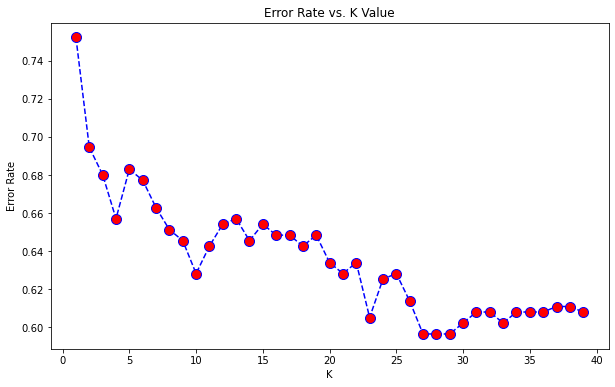

In [41]:
# let's plot our error vs k to visualize the best k
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-", min(error_rate),"at K =", error_rate.index(min(error_rate)))

from the visualization, it appears that k = 26 is the optimal solution for k and it will give us the minimum error.<br>
Let's make sure by plottinh the accuracy Vs K.

Maximum accuracy:- 0.4034582132564842 at K = 26


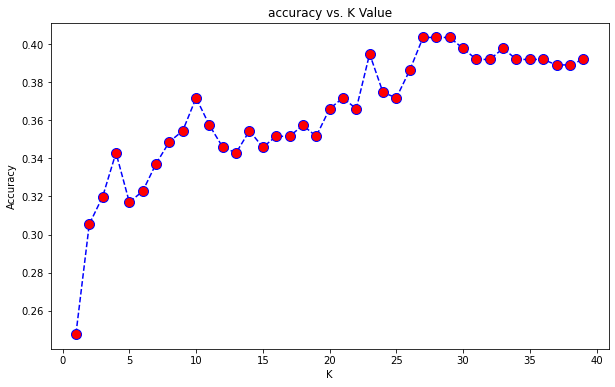

In [42]:
acc = []
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

as we got before, the best k is 26, it will give us the min error and max accuracy for our model.

In [43]:
k = 26  # let's train using our optimal k 
KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = KNN.predict(X_test)
print("Accuracy of model at K=26 is",metrics.accuracy_score(y_test, Pred_y))

Accuracy of model at K=26 is 0.3861671469740634


In [44]:
Pred_y

array([ 0., 11.,  0.,  0.,  0.,  0.,  1.,  1., 11.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  1.,  0., 11.,  0.,  0.,  8., 11.,  0.,  1.,
        1.,  0.,  0.,  1.,  1., 11.,  0., 11.,  0.,  1.,  1.,  0.,  0.,
        0., 11.,  8.,  0.,  0.,  1.,  2.,  1., 11.,  0.,  1.,  1.,  1.,
       11.,  0.,  0.,  0.,  0., 11.,  0.,  0.,  0., 11.,  0.,  0., 11.,
        1.,  0., 11.,  0., 11.,  0.,  1.,  1.,  8.,  1.,  1., 11.,  0.,
        1.,  1.,  2.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0., 11.,  0., 11.,  0.,  8.,  1.,  0.,  1.,  8., 11.,  0., 11.,
        0.,  0.,  2.,  0.,  0.,  8.,  0.,  0., 11.,  8., 11.,  1.,  0.,
        0., 11.,  2.,  0.,  4.,  1.,  0.,  1.,  1.,  1.,  0.,  1., 11.,
        0.,  0.,  1.,  1., 11.,  1.,  1.,  0.,  0.,  1.,  0.,  8., 11.,
        0.,  0.,  0., 11.,  0., 11.,  2.,  0.,  0., 11., 11.,  0.,  1.,
        0.,  1.,  0.,  8.,  1., 11.,  0., 11.,  0.,  1., 11.,  0., 11.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0

**After training using 3 different models, it appears that the model which gives us the highest accuracy is Naive Bayes model with accuracy = 75%.**

# 5)List of Keywords

In [46]:
#set of unique words
Listwordset=[]
for row in range(data.shape[0]):
        #for column in range(data.shape[1]):
        for token in data.iloc[row][4]:
            if token not in wordset:
                Listwordset.append(token)
    

In [47]:
print(len(Listwordset))

0


In [48]:
#function returns the dictionary of the dataset
def ListDictionary(data, wordset):
    word_dict=dict.fromkeys(wordset, 0)
    for row in range(0,data.shape[0]):      
        #for column in range(data.shape[1]):
        for token in data.iloc[row][4]:
             word_dict[token] += 1
    return word_dict
#print(Dictionary(data,wordset))

In [49]:
#function takes row number and returns tokens in the whole row
def Listrow_tokens(row):
    tokens=[]
    #for column in range(data.shape[1]):
    for token in data.iloc[row][4]:
        tokens.append(token)
    return tokens
print(Listrow_tokens(1))

['مُصَوِّر', 'طِفْل', 'كِتاب', 'جَمِيل', 'مَصْنُوع', 'وَرَق', 'مُقَوَّى', 'تَعْرِيف', 'طِفْل', 'طَبِيعَة', 'فَصْل', 'سَنَة', 'ٱِسْم', 'حال', 'جَوِّيّ', 'صُورَة', 'مُلَوَّن', 'جَمِيل']


In [50]:
#function make dictionary for a row
def ListrowDict(row,wordset):
    word_dict=dict.fromkeys(wordset, 0)
    #for column in range(data.shape[1]):
    for token in data.iloc[row][4]:
        word_dict[token] += 1
    return word_dict

#function make dictionary array by which each index in the array is the dictionary of row at that index
def Listrow_Dictionary(data,wordset):
    dict=[]
    for row in range(0,data.shape[0]):
        dict.append(rowDict(row,wordset))
    return dict
#print(row_Dictionary(data,wordset))

In [27]:
dictionary=ListDictionary(data,Listwordset) #retrieve the dictionary for the whole file
Tf=[]
Idf=compute_idf(Listrow_Dictionary(data,Listwordset))
TfIdf=[]
for i in range(0,data.shape[0]):
    #if (len(row_tokens(i))!=0):
    Tf.append(compute_tf(dictionary,Listrow_tokens(i)))
    TfIdf.append(compute_tf_idf(Tf[i],Idf))
    #else:
        #break
print(len(TfIdf), len(TfIdf[0]))
print(type(TfIdf), type(TfIdf[0]))
#TfIdf[0]

1386 8713
<class 'list'> <class 'dict'>


In [66]:
def get_sorted(dic):
    result = dict(sorted(dic.items(),key= lambda x:x[1])) 
    return result

In [72]:
listOfKeywords=[]
for i in range(len(TfIdf)):
    sort=get_sorted(TfIdf[i])
    key_list = [key for key in sort]
    onerow=[]
    for j in range(5):
        onerow.append(key_list[j])
    listOfKeywords.append(onerow)
    
print(listOfKeywords[0])

['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة']


In [73]:
print(listOfKeywords)

[['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة'], ['جَمْعِيَّة', 'أَوْجَع', 'بَبْغاء', 'لَعُوب', 'زَرافَة